# Dropout for Quantum Neural Networks

Here we show how to exploit the quantum version of dropout technique to avoid the problem of overfitting in Quantum Machine Learning. The following demo is based on the paper "A general approach dropout in Quantum Neural Networks" by F. Scala, et al. [1].

## What are overfitting and dropout?

Machine learning (ML) usually requires highly flexible models with lots of trainable parameters in order to *learn* a certain underlying function (or data distribution) throughout an optimization process. However, being able to learn with low in-sample error is not enough: it is also desirable to have a model capable of high *generalization*, meaning that it is able of providing good predictions on previously unseen data.

Highly expressive model may incurr in the so called ***overfitting*** phenomenon, which means that they are trained too well on the training data, and as a result, performs poorly on new, unseen data.  This happens because the model has learnt the noise in the training data, rather than the underlying pattern that is generalizable to new data.

***Dropout*** is a common technique for classical Deep Neural Networks preventing computational units from becoming too specialized and reducing the risk of overfitting. It consists in randomly remove neurons along with their connections *only during training* to block the information flow. Once the model is trained the Neural Network is employed in its original form.

## Why dropout for Quantum Neural Networks?

Recently, it has been shown that the use of overparametrized Quantum Neural Network (QNN) models changes the optimization landascape removing lots of local minima [2]. If this increased number of parameters, on the one hand, leads to faster and easier training, on the other hand, it may drive the model to overfit the data. This is also strictly related to the repated encoding of classical data to achieve nonlinearity in the computation [4-6]. This is why, inspired from classical ML, one can think of apply some sort of dropout also to QNNs. This would correspond to randomly drop some (groups of) parametrized gates during training to achieve better generalization.

## Quantum dropout of rotations in `sin` regression

In this tutorial we will exploit quantum dropout to avoid overfitting during the regression of noisy data originally coming from the *sinusoidal* function. In particular, we will randomly "drop" rotations during the training phase. This in practice will correspond to temporarly set to 0 some  random parameters at each iteration step during the optimization.

Let's start by import the useful libraries for this demo:

In [1]:
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import jax # require for Just In Time (JIT) compilation

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

sns.set()

seed = 12345
np.random.seed(seed=seed)

### The circuit

Now we define the embedding of classical data and the variational anstaz that will then be combined to construct our QNN.

In [2]:
def embedding(x, wires):
    # Encodes the datum multiple times in the register,
    # employing also nonlinear functions
    assert len(x)==1
    for i in wires:
        qml.RY(jnp.arcsin(x), wires=i)
    for i in wires:
        qml.RZ(jnp.arccos(x**2), wires=i)

def true_cond(angle):
    # necessary for using an if statement within jitted function
    # exploiting jax.lax.cond
    # if this function is assessed the rotation is dropped
    return 0.0
def false_cond(angle):
    # necessary for using an if statement within jitted function
    # exploiting jax.lax.cond
    # if this function is assessed the rotation is kept
    return angle

def var_ansatz(theta, wires, rotations = [qml.RX, qml.RZ,qml.RX], entangler = qml.CNOT, keep_rotation=None): 
    # the length of `rotations` defines the number of inner layers
    N = len(wires)
    assert len(theta) == 3 * N
    wires = list(wires)
    
    counter = 0
    #keep_rotations contains a list per inner_layer
    for rots in keep_rotation: 
        # we cicle over the indexes i of the inner layer
        for qb,i in enumerate(rots): 
            rot = rotations[counter] # each inner layer can have a different rotation
            
            angle = theta[counter*N+qb]
            # conditional statement implementing dropout
            # if the index is negative the rotation is dropped
            angle_drop = jax.lax.cond(i<0, true_cond, false_cond,angle)
            rot(angle_drop, wires=wires[qb])
        for qb in wires[:-1]:
            entangler(wires=[wires[qb], wires[qb+1]])
        counter += 1
    

And then we define the hyperparameters of our QNN, namely the number of qubits, the number of layers, the number of sublayers in the variational ansatz (`inner_layers`) and the resulting number of parameters per layer:

In [3]:
n_qubits = 5
layers = 10
inner_layers = 3
params_per_layer = n_qubits*inner_layers

Here below we actually build the QNN:

In [4]:

def create_circuit(n_qubits, layers):

    device = qml.device("default.qubit.jax", wires=n_qubits)
    

    @qml.qnode(device,interface='jax')
    def circuit(x, theta, keep_rot):
        #print(x)
        #print(theta)
        
        for i in range(layers):
            
            embedding(x, wires=range(n_qubits))

            keep_rotation = keep_rot[i]
            
            var_ansatz(theta[i * params_per_layer: (i + 1) * params_per_layer], wires=range(n_qubits),
                            entangler = qml.CNOT, 
                            keep_rotation=keep_rotation)
            
        return qml.expval(qml.PauliZ(wires=0)) # we measure only the first qubit
    return circuit

Let's have a look at single layer of our QNN:

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

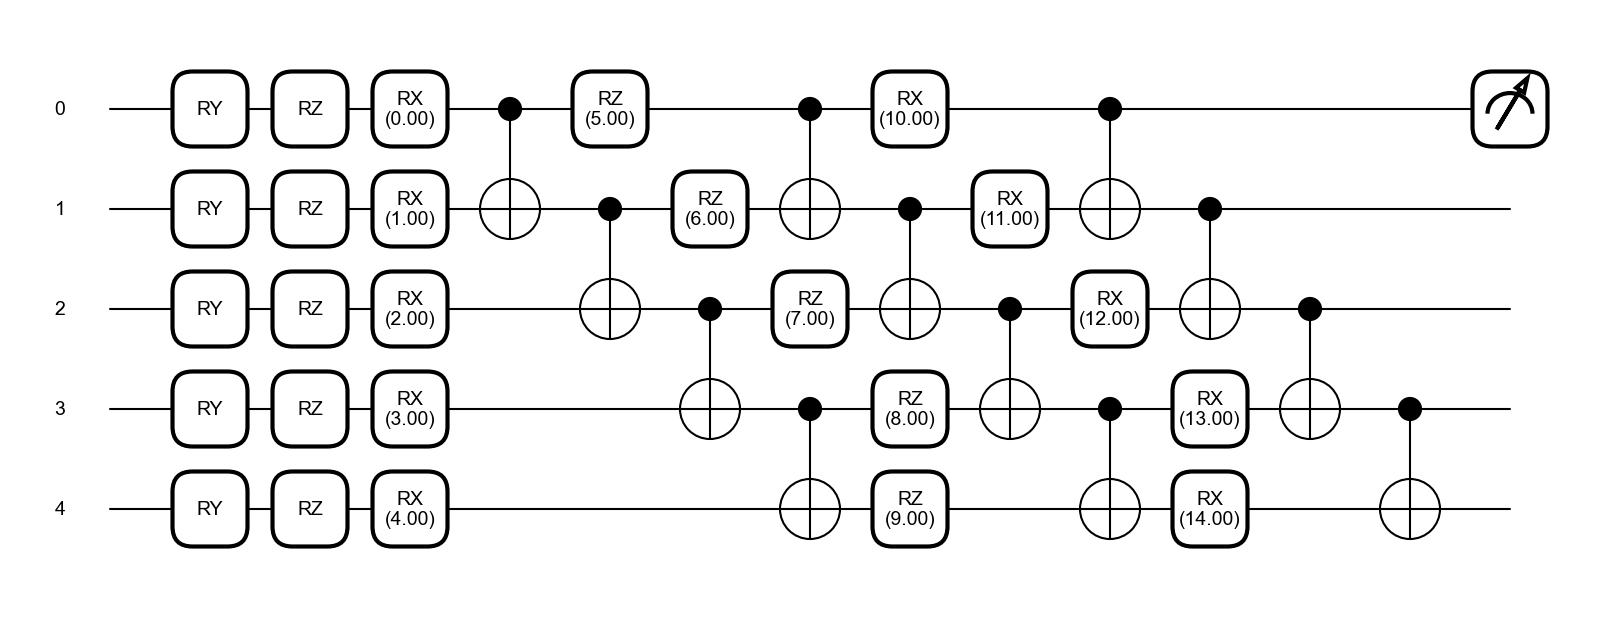

In [5]:
# create the circuit with given number of qubits and layers
circ = create_circuit(n_qubits, layers=1)

#for the moment let's keep all the rotations in all sublayers
keep_all_rot = [[list(range((n_qubits)))  for j in range(1,inner_layers+1)], ]
# we count the parameters
numbered_params = np.array(range(params_per_layer*layers), dtype=float)
# we encode a single coordinate
single_sample = np.array([0])

qml.draw_mpl(circ,decimals=2,)(single_sample, numbered_params, keep_all_rot)

We now build the model that we will employ for the regression task with 10 layers and we exploit `JAX` to speed the training up:

In [6]:
qnn_tmp = create_circuit(n_qubits, layers)
qnn_tmp = jax.jit(qnn_tmp)
qnn_batched = jax.vmap(qnn_tmp, (0, None, None))#we want to vmap on 0-axis of the first circuit param
                                                # in this way we process in parallel all the inputs
# We jit for faster execution
qnn = jax.jit(qnn_batched)  # 


### Dropping rotations

As anticipated, we need to set some random parameters to 0 at each optimization step. Given a layer dropout rate $p_L$ and the gate dropout rate $p_G$, the probability $p$ that a (group of) gate(s) is dropped in a layer can be calculated with the conditioned probability law:
$$
p=p(A\cap B)=p(A|B)p(B)=p_Gp_L
$$
where $A$ is the selection of a specific (group of) gate(s) and $B$ is the selection of a specific layer.

In the following cell we define a function providing a list of the indexes of rotation gates that are kept and for those which need to dropped the value `-1` is assigned. This will be called at each iteartion.

In [7]:
def make_dropout(key):

    drop_layers = []

    for lay in range(layers):
        # each layer has prob p=layer_drop_rate of being dropped
        # according to that for every layer we sample
        # if we have to appy dropout in it or not
        out = jax.random.choice(key, jnp.array(range(2)), p=jnp.array([1-layer_drop_rate, layer_drop_rate]))
        key = jax.random.split(key)[0] #update the random key
        
        if out==1:# if it has to be dropped
            drop_layers.append(lay)
 

    
    keep_rot = []
    # we make list of indexes corresponding to the rotations gates
    # that are kept in the computation during a single train step
    for i in range(layers):
        # each list is divded in layers and then in "inner layers" 
        # this is strictly related to the QNN architecture that we use
        keep_rot_layer = [list(range((n_qubits)))  for j in range(1,inner_layers+1)]
        
        if i in drop_layers: # if dropout has to be applied in this layer
            
            
            keep_rot_layer = [] # list of indexes for a single layer
            inner_keep_r =[] # list of indexes for a single inner layer
            for param in range(params_per_layer):
                # each rotation within the layer has prob p=rot_drop_rate of being dropped
                # according to that for every parameter (rotation) we sample 
                # if we have to drop it or not
                out = jax.random.choice(key,jnp.array(range(2)), p=jnp.array([1-rot_drop_rate, rot_drop_rate]))
                key = jax.random.split(key)[0] # update the random key
                
                if out==0: # if we have to keep it
                    inner_keep_r.append(param%n_qubits)# % is required because we work 
                                                        # inner layer by inner layer
                else: # if the rotation has to be dropped
                    inner_keep_r.append(-1) # we assign the value -1
                    
                if param%n_qubits == n_qubits-1: # if it's the last qubit of the register
                    # append the inner layer list
                    keep_rot_layer.append(inner_keep_r)
                    # and reset it
                    inner_keep_r = []
        
        keep_rot.append(keep_rot_layer)
    # print('len of drop layers', len(drop_layers))
    # print(drop_layers)
    # print('keep rot', keep_rot)
    # print(len(keep_rot))
    # print('---------------')
    return   jnp.array(keep_rot)

We can check the output of the `make_dropout` function:

In [8]:
# setting the drop probability
layer_drop_rate, rot_drop_rate = 0.5, 0.3 # 15% probability of dropping a gate

# JAX random key
key = jax.random.PRNGKey(12345)
# create the list of indexes,
# -1 implies we are dropping a gate
keep_rot = make_dropout(key)

# let's just print the list for first layer
print(keep_rot[0])

[[ 0 -1  2 -1  4]
 [ 0 -1 -1  3  4]
 [-1  1 -1  3  4]]


### Noisy sinusoidal function

Create $\sin$ dataset in presence of additive white Gaussian noise (noise with normal ditribution) $\epsilon$:

In [9]:
def make_sin_dataset(dataset_size = 100, test_size=0.4, noise_value=0.4, plot=False):

    '''1D regression problem y=sin(x*\pi)'''
    x_ax = np.linspace(-1,1,dataset_size)
    y = [[np.sin(x*np.pi)] for x in x_ax]
    np.random.seed(123)
    # noise vector
    noise = np.array([np.random.normal(0,0.5,1) for i in y])*noise_value
    X = np.array(x_ax)
    y = np.array(y+noise)# apply noise

    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=40, shuffle=True)


    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

    return X_train, X_test, y_train, y_test

X, X_test, y, y_test = make_sin_dataset(dataset_size = 20, test_size=0.25)



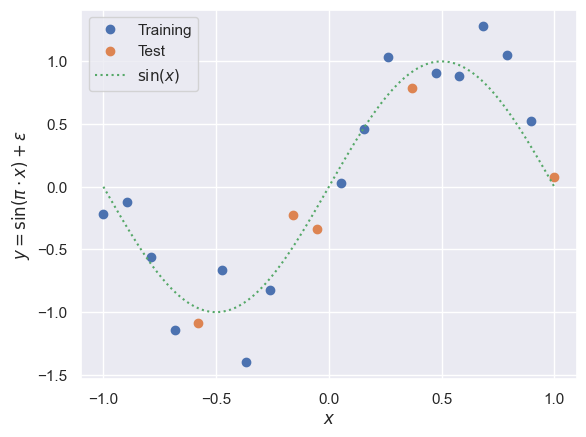

In [10]:
fig, ax = plt.subplots()
plt.plot(X,y,'o', label='Training')
plt.plot(X_test,y_test, 'o',label='Test')

plt.plot(np.linspace(-1,1,100),[np.sin(x*np.pi)for x in np.linspace(-1,1,100)], linestyle='dotted', label=r'$\sin(x)$')
plt.ylabel(r'$y = \sin(\pi\cdot x) + \epsilon$')
plt.xlabel(r'$x$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.legend()

plt.show() 

Since our circuit is only able to provide outputs in the range $[-1,1]$ we rescale all the noisy data within this range. We fit the scaler from training data and then we apply it also to the test (and validation?). This in general may lead to some values scaled out of the desired range if the trainig dataset is not fully representative.

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))                                        
y = scaler.fit_transform(y)
y_test = scaler.transform(y_test)

# reshaping for computation
y=y.reshape(-1,)
y_test=y_test.reshape(-1,)

### Optimization

At this we have to set the hyperparameters of the optimization, namely the number of epochs, the learning rate and the optimizer:

In [12]:
epochs = 500
optimizer = optax.adam(learning_rate=0.01)

And the cost function, which in this case is the Mean Square Error:

In [13]:
@jax.jit
def calculate_mse_cost(X, y, theta, keep_rot):
    
    yp = qnn(X, theta, keep_rot)   
    # depending on your version of Pennylane you may require the following line
    #####
    yp = jnp.array(yp).T
    #####
    cost = jnp.mean((yp - y) ** 2)
    
    return cost

In [14]:
# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, keep_rot):
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,  keep_rot))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    # print('updates------\n')
    # f=np.array(drop_rot).flatten()
    # h = optax.apply_updates(params, updates)
    # for i in zip(jnp.asarray(updates),f, params, h):
    #              print(i)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

## Training the model

And now we can try to train the model. We execute different runs of the training to understand the average behaviour of quantum dropout. To see the effect of dropout we can set different values of `layer_drop_rate` and `rot_drop_rate`:

In [15]:
n_run = 3
drop_rates = [(0.,0.), (0.1, 0.1), (0.3, 0.2), (0.7, 0.7)]

In [16]:
train_history = {}
test_history = {}
opt_params = {}


for layer_drop_rate, rot_drop_rate in drop_rates:
    # initialization of some lists to store data
    costs_per_comb = []
    test_costs_per_comb = []
    opt_params_per_comb = []
    # we execute multiple runs in order to see the average behaviour
    for tmp_seed in range(seed, seed+n_run):
        key = jax.random.PRNGKey(tmp_seed)
        assert len(X.shape) == 2 # X must be a matrix
        assert len(y.shape) == 1  # y must be an array
        assert X.shape[0] == y.shape[0] # compatibility check

        # parameters initialization with gaussian ditribution
        initial_params = jax.random.normal(key, shape=(layers * params_per_layer,))
        # update the random key
        key = jax.random.split(key)[0]

        params = jnp.copy(initial_params)

        # optimizer initialization
        opt_state = optimizer.init(initial_params)

        # lists for saving single run training and test cost trend
        costs = []
        test_costs = []

        for epoch in range(epochs):

            # generate the list for dropout
            keep_rot = make_dropout( key)
            # update the random key
            key = jax.random.split(key)[0]

            # optimization step
            params, opt_state, cost = optimizer_update(opt_state, params, X, y,keep_rot)
        
            ############## performance evaluation #############
            # inference is done with the original model
            # with all the gates
            keep_rot = jnp.array([[list(range((n_qubits)))  for j in range(1,inner_layers+1)]for i in range(layers)])
            cost = calculate_mse_cost(X, y, params, keep_rot)

            costs.append(cost)
            
            test_cost = calculate_mse_cost(X_test, y_test, params, keep_rot)
            test_costs.append(test_cost)
            
            # we print updates every 5 iterations
            if epoch%5==0:    
                print(f'{layer_drop_rate}-{rot_drop_rate}',f"run {tmp_seed-seed} - epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')

        costs_per_comb.append(costs)
        test_costs_per_comb.append(test_costs)
        opt_params_per_comb.append(params)
        print()
    costs_per_comb = np.array(costs_per_comb)
    test_costs_per_comb = np.array(test_costs_per_comb)
    opt_params_per_comb = np.array(opt_params_per_comb)

    train_history[(layer_drop_rate, rot_drop_rate)] = costs_per_comb
    test_history[(layer_drop_rate, rot_drop_rate)] = test_costs_per_comb
    opt_params[(layer_drop_rate, rot_drop_rate)] = opt_params_per_comb

0.0-0.0 run 0 - epoch 495/500 --- Train cost: 0.00023795867069351302 --- Test cost: 0.11025906021758224
0.0-0.0 run 1 - epoch 495/500 --- Train cost: 0.0003679011126631143 --- Test cost: 0.098570672883149025
0.0-0.0 run 2 - epoch 495/500 --- Train cost: 0.0001458167396862056 --- Test cost: 0.134809752542477938
0.1-0.1 run 0 - epoch 495/500 --- Train cost: 0.009922959089127483 --- Test cost: 0.0424747579631815764
0.1-0.1 run 1 - epoch 495/500 --- Train cost: 0.009975738720491834 --- Test cost: 0.0515725767782623946
0.1-0.1 run 2 - epoch 495/500 --- Train cost: 0.007069009773208149 --- Test cost: 0.033115198424497755
0.3-0.2 run 0 - epoch 495/500 --- Train cost: 0.021484078600851036 --- Test cost: 0.023731416715207485
0.3-0.2 run 1 - epoch 495/500 --- Train cost: 0.02984411177894358 --- Test cost: 0.0202635663171436434
0.3-0.2 run 2 - epoch 495/500 --- Train cost: 0.0200378626758027 --- Test cost: 0.05465017321541535775
0.7-0.7 run 0 - epoch 495/500 --- Train cost: 0.34858649345734216 --

## Performance evaluation

Let's compare the difference in performance with a plot:

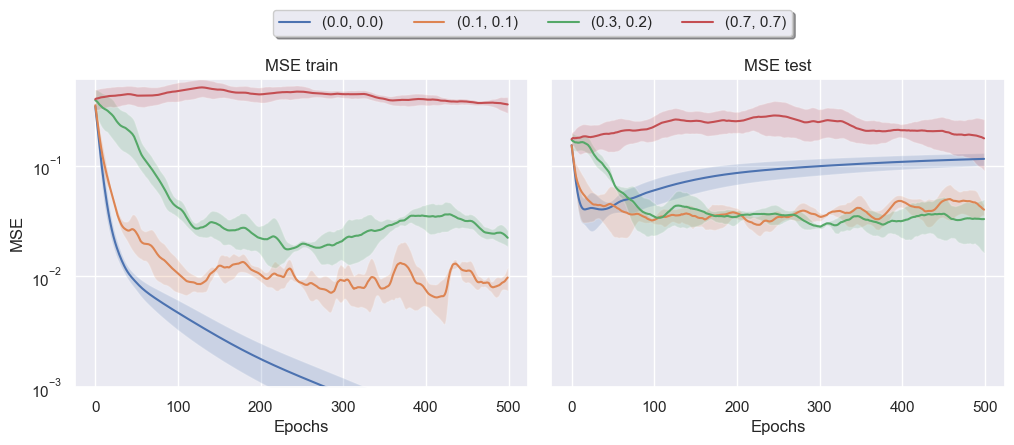

In [17]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.05)
axs[0].set_title('MSE train')
for k,v in train_history.items():

    train_losses = np.array(v)
    mean_train_history = np.mean(train_losses,axis=0)
    std_train_history = np.std(train_losses,axis=0,)

    mean_train_history = mean_train_history.reshape((epochs,))
    std_train_history = std_train_history.reshape((epochs,))

    # shadow standard deviation
    axs[0].fill_between(range(epochs),  mean_train_history - std_train_history, 
                mean_train_history + std_train_history, 
                alpha=0.2)
    #average trend
    axs[0].plot(range(epochs), mean_train_history, label=f'{k}')#Avg Loss

axs[1].set_title('MSE test')
for k,v in test_history.items():

    test_losses = np.array(v)
    mean_test_history = np.mean(test_losses,axis=0)
    std_test_history = np.std(test_losses,axis=0,)

    mean_test_history = mean_test_history.reshape((epochs,))
    std_test_history = std_test_history.reshape((epochs,))

    # shadow standard deviation
    axs[1].fill_between(range(epochs),  mean_test_history - std_test_history, 
                mean_test_history + std_test_history, 
                alpha=0.2)
    # averange trend
    axs[1].plot(range(epochs), mean_test_history, label=f'{k}')#Avg Loss

axs[0].legend(loc='upper center', bbox_to_anchor=(1.01, 1.25),
          ncol=4, fancybox=True, shadow=True)

for ax in axs.flat:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    ax.set_yscale('log')
    ax.set_ylim([1e-3, 0.6])
    ax.label_outer()

On the left you can see that without dropout allows a deep minimization of the training loss, moderate values of dropout converges, whereas high drop probabilities impede the any learning. On the right plot we can see the difference in generalization during the optimization process. Standard training without dropout initially reaches a low value of generalization error, but then, as the model starts to learn the noise in the training data (overfitting), the generalization error grows back. Opposite, moderate values of dropout enable generalization errors comparable to the respective training ones. As the learning is not succesful for elevated drop probabilities the generalization error is huge. It is interesting to notice that the "not-learning" error is very close to the final error of the QNN trained without dropout.

Hence, one can conclude that low values of dropout greatly improve the generalization performance of the model and remove overfitting, even if the randomness of the technique inevitably makes the training a little noisy. On the other hand, high drop probabilities only hinders the training process. 

### Validation 

To validate the technique we can also check how the model predict in the whole $[-1,1]$ range with and without quantum dropout.

In [1]:
X, X_test, y, y_test = make_sin_dataset(dataset_size = 20, test_size=0.25)


NameError: name 'make_sin_dataset' is not defined

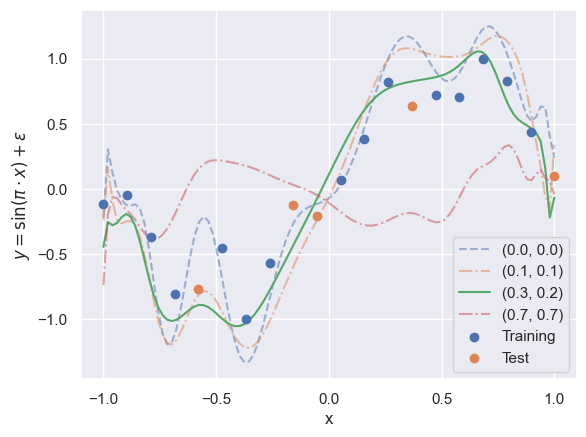

In [19]:
# spanning the whole range
x_ax = jnp.linspace(-1,1,100).reshape(100,1)

# selecting which run we want to plot
run = 1

fig, ax = plt.subplots()
styles = ['dashed', '-.','solid','-.' ]
for i, k in enumerate(train_history.keys()):
    if k[0] == 0.3:
        alpha = 1
    else:
        alpha = 0.5
    # predicting and rescaling
    yp = scaler.inverse_transform(qnn(x_ax, opt_params[k][run], keep_rot).reshape(-1, 1)) 
    plt.plot([[i] for i in np.linspace(-1,1,100)], yp, label=k, 
             alpha=alpha, linestyle=styles[i])

plt.scatter(X,y, label='Training', zorder=10)
plt.scatter(X_test,y_test,label='Test', zorder=10)

ylabel = r'$y = \sin(\pi\cdot x) + \epsilon$'
plt.xlabel('x', fontsize='medium')
plt.ylabel(ylabel, fontsize='medium')
plt.legend()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

The model without dropout overfits the noisy data by trying to exactly predicting each of them, whereas dropout actually mitigates overfitting and makes the approximation of the underlying `sin` function way smoother.